<a href="https://colab.research.google.com/github/Suyeon-j/study_oml/blob/main/240312/m_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!! pip install -U open-metric-learning

['Requirement already satisfied: open-metric-learning in /usr/local/lib/python3.10/dist-packages (2.1.6)',
 'Requirement already satisfied: torch<=2.1.1,>=2.0 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (2.1.1)',
 'Requirement already satisfied: pytorch-lightning<=2.1.2,>=2.0 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (2.1.2)',
 'Requirement already satisfied: torchvision<=0.16.1 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (0.16.1)',
 'Requirement already satisfied: albumentations<=1.3.1,>=1.0 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (1.3.1)',
 'Requirement already satisfied: opencv-python>=4.1.1 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (4.8.0.76)',
 'Requirement already satisfied: pillow>=8.2 in /usr/local/lib/python3.10/dist-packages (from open-metric-learning) (9.4.0)',
 'Requirement already satisfied: pandas>=1.0 in /usr/local/lib/python3.10/

In [ ]:
import torch
from tqdm import tqdm

from oml.datasets.base import DatasetQueryGallery
from oml.metrics.embeddings import EmbeddingMetrics
from oml.models import ViTExtractor
from oml.utils.download_mock_dataset import download_mock_dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset_root =  "mock_dataset/"
# _, df_val = download_mock_dataset(dataset_root)
# df_val.head()

In [ ]:
import os
os.chdir("/content/drive/MyDrive/2024_공부/OML/")
import sqlite3

conn = sqlite3.connect('img/m_img.db')
cursor = conn.cursor()

# DF 타입 출력
import pandas as pd

cursor.execute("SELECT * FROM m_img;")
rows = cursor.fetchall()

cols = [column[0] for column in cursor.description]

df = pd.DataFrame.from_records(data=rows, columns=cols)
conn.close()

In [ ]:
import pandas as pd

df_val = df[df['split'] == "validation"]
dataset_root = "img/MAN/"

In [ ]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 원하는 크기로 조정
    transforms.ToTensor(),  # 텐서로 변환
])

In [ ]:
model = ViTExtractor("vits16_dino", arch="vits16", normalise_features=False).eval()
val_dataset = DatasetQueryGallery(df_val, dataset_root=dataset_root, transform=image_transform)
val_dataset.df

https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth


,label,path,split,is_query,is_gallery
15,5,img/MAN/Seongchan01.jpeg,validation,1,0
16,5,img/MAN/Seongchan02.jpeg,validation,0,1
17,5,img/MAN/Seongchan03.jpeg,validation,0,1
18,6,img/MAN/Seonu01.jpg,validation,1,0
19,6,img/MAN/Seonu02.jpg,validation,0,1
20,6,img/MAN/Seonu03.jpg,validation,0,1
21,7,img/MAN/Sinyu01.jpg,validation,1,0
22,7,img/MAN/Sinyu02.jpeg,validation,0,1
23,7,img/MAN/Sinyu03.jpeg,validation,0,1


In [ ]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4)
calculator = EmbeddingMetrics(extra_keys=["paths",])
calculator.setup(num_samples=len(val_dataset))

In [ ]:
with torch.no_grad():
    for batch in tqdm(val_loader):
        batch["embeddings"] = model(batch["input_tensors"])
        calculator.update_data(batch)

100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


In [ ]:
metrics = calculator.compute_metrics()


Metrics:
{'OVERALL': {'cmc': {5: tensor(1.)},
             'map': {5: tensor(0.4444)},
             'pcf': {0.5: tensor(0.0078)},
             'precision': {5: tensor(0.6667)}}}


In [ ]:
# Logging
print(calculator.metrics)  # metrics
print(calculator.metrics_unreduced)  # metrics without averaging over queries

{'OVERALL': {'cmc': {5: tensor(1.)}, 'precision': {5: tensor(0.6667)}, 'map': {5: tensor(0.4444)}, 'pcf': {0.5: tensor(0.0078)}}}
{'OVERALL': defaultdict(<class 'dict'>, {'cmc': {5: tensor([1., 1., 1.])}, 'precision': {5: tensor([0.5000, 0.5000, 1.0000])}, 'map': {5: tensor([0.3333, 0.5000, 0.5000])}, 'pcf': {0.5: tensor(0.0078)}})}


Draw predictions for predefined queries


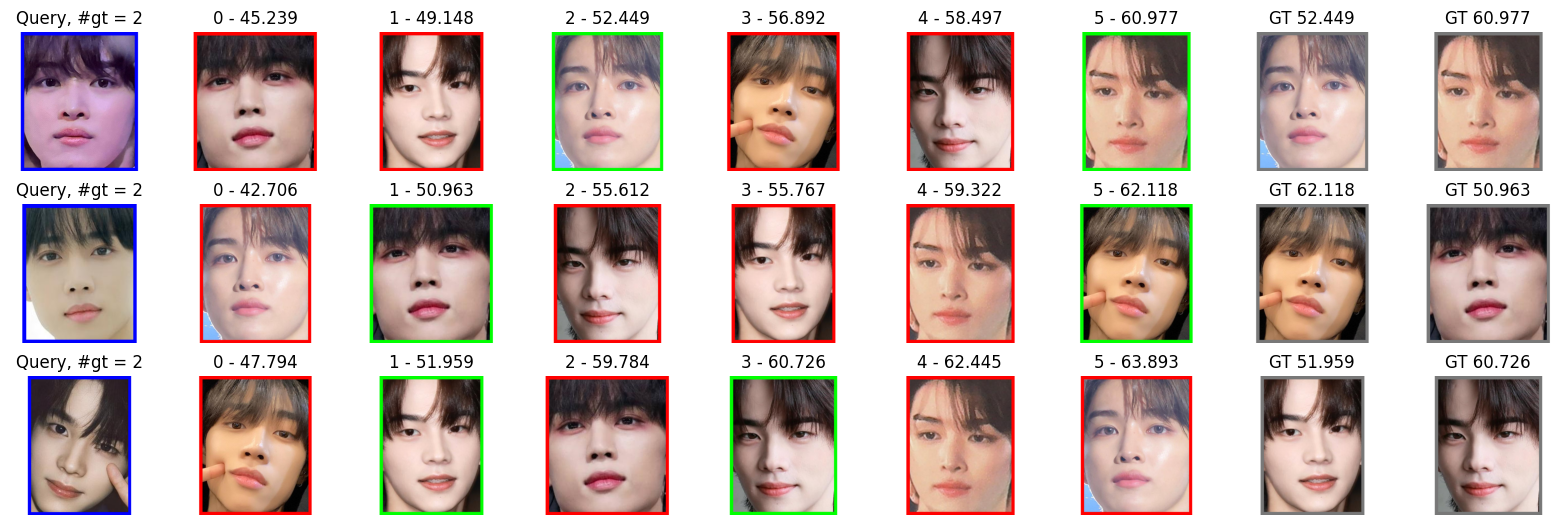

In [ ]:
import matplotlib.pyplot as plt

# Visualisation
print("Draw predictions for predefined queries")
calculator.get_plot_for_queries(query_ids=[0, 1, 2], n_instances=6, verbose=False)
plt.show()

Draw the queries worst by map@5


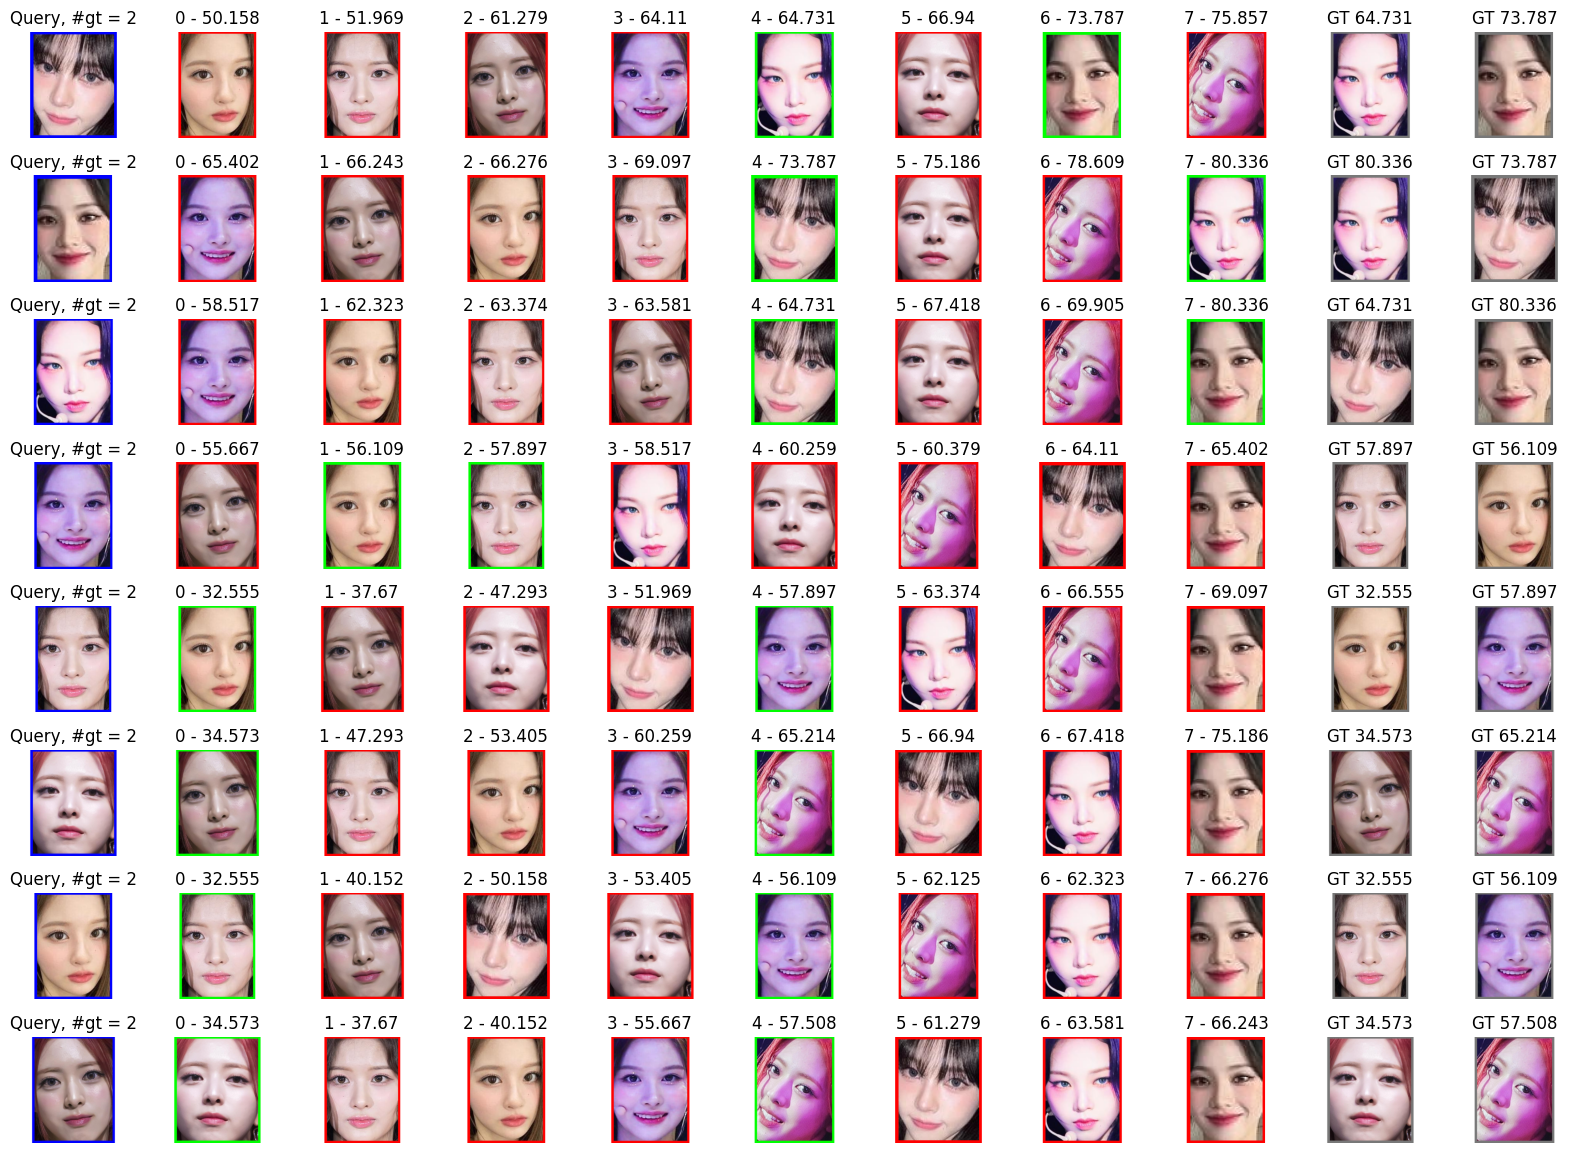

In [ ]:
print("Draw the queries worst by map@5")
calculator.get_plot_for_worst_queries(metric_name="OVERALL/map/5", n_queries=8, n_instances=8, verbose=False)
plt.show()

Q   img/MAN/Seongchan01.jpeg
G 0 img/MAN/Seonu03.jpg
G 1 img/MAN/Sinyu02.jpeg
G 2 img/MAN/Seongchan02.jpeg
G 3 img/MAN/Seonu02.jpg
G 4 img/MAN/Sinyu03.jpeg
G 5 img/MAN/Seongchan03.jpeg
Q   img/MAN/Seonu01.jpg
G 0 img/MAN/Seongchan02.jpeg
G 1 img/MAN/Seonu03.jpg
G 2 img/MAN/Sinyu03.jpeg
G 3 img/MAN/Sinyu02.jpeg
G 4 img/MAN/Seongchan03.jpeg
G 5 img/MAN/Seonu02.jpg
Q   img/MAN/Sinyu01.jpg
G 0 img/MAN/Seonu02.jpg
G 1 img/MAN/Sinyu02.jpeg
G 2 img/MAN/Seonu03.jpg
G 3 img/MAN/Sinyu03.jpeg
G 4 img/MAN/Seongchan03.jpeg
G 5 img/MAN/Seongchan02.jpeg


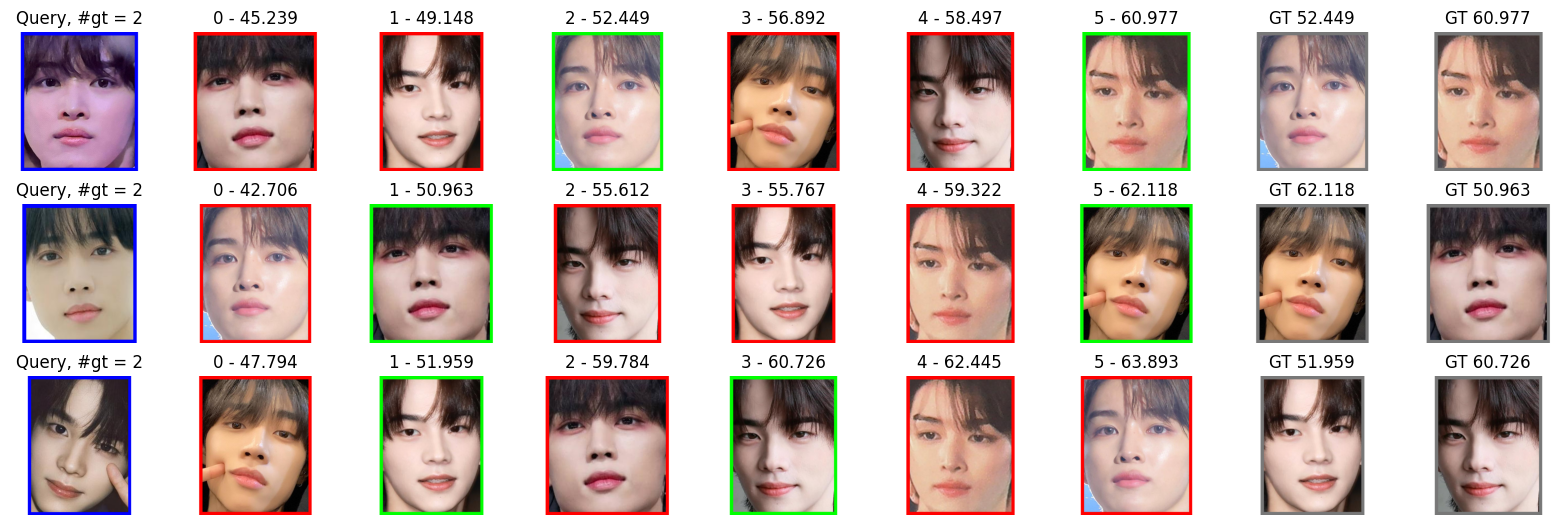

In [ ]:
calculator.get_plot_for_queries(query_ids=[0, 1, 2], n_instances=6, verbose=True)
plt.show()

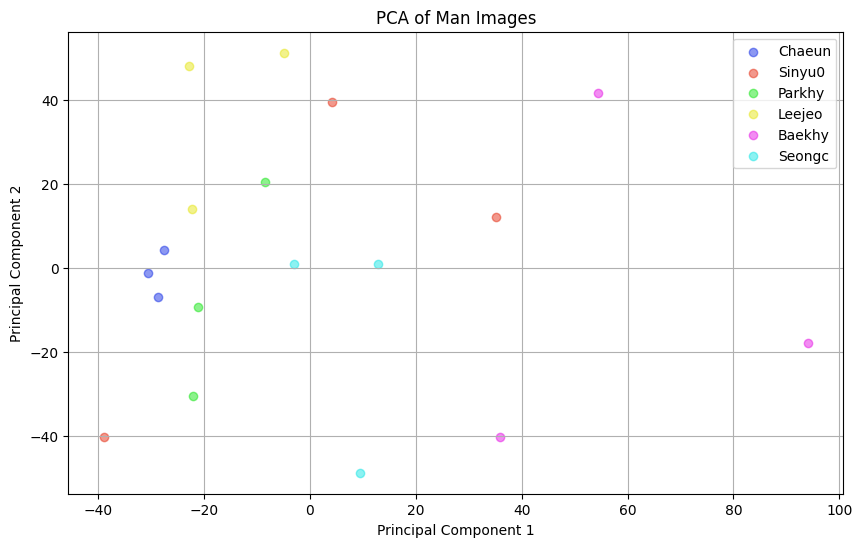

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torchvision import transforms

# 이미지 파일 폴더 경로
image_fpaths = '/content/drive/MyDrive/2024_공부/OML/img/MAN'

# 이미지 파일 목록 가져오기
image_files = os.listdir(image_fpaths)

# 이미지를 벡터로 변환하는 함수
def image_to_vector(image_path):
    image = Image.open(image_path).convert('RGB')

    image = image_transform(image)
    return image.flatten().numpy()  # 이미지를 1차원 벡터로 변환하여 반환

# 이미지를 벡터로 변환하고 이미지 이름을 그룹화한 후, 각 그룹의 색상을 결정
image_vectors = []
image_groups = []
for file_name in image_files:
    image_path = os.path.join(image_fpaths, file_name)
    image_vector = image_to_vector(image_path)
    image_vectors.append(image_vector)
    image_group = file_name[:6]  # 이미지 이름의 앞 6글자를 그룹화
    image_groups.append(image_group)

# 벡터 데이터를 numpy 배열로 변환
image_vectors = np.array(image_vectors)

# PCA 모델 초기화 및 학습
pca = PCA(n_components=2)  # 2차원으로 축소
pca.fit(image_vectors)

# PCA를 통해 데이터 변환
transformed_data = pca.transform(image_vectors)

# 각 그룹의 대표 색상 선택
unique_groups = list(set(image_groups))
colors = [
    (0.1, 0.2, 0.9),  # 첫 번째 그룹의 색상 (파란색)
    (0.9, 0.2, 0.1),  # 두 번째 그룹의 색상 (빨간색)
    (0.1, 0.9, 0.1),  # 세 번째 그룹의 색상 (초록색)
    (0.9, 0.9, 0.1),  # 네 번째 그룹의 색상 (노란색)
    (0.9, 0.1, 0.9),  # 다섯 번째 그룹의 색상 (자주색)
    (0.1, 0.9, 0.9),  # 여섯 번째 그룹의 색상 (하늘색)
]

# 시각화
plt.figure(figsize=(10, 6))
for group, color in zip(unique_groups, colors):
    group_indices = [i for i, g in enumerate(image_groups) if g == group]
    group_data = transformed_data[group_indices, :]
    plt.scatter(group_data[:, 0], group_data[:, 1], c=[color], label=group, alpha=0.5)
plt.title('PCA of Man Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend()
plt.show()